# Classification de profils des prorfils avec du __clustering__: 
#### _Étude de profil d’aile d’avion par Machine Learning_ - _Université de Sherbrooke_
#### 
__Auteur__ : _Ilyas Baktache_  
__Année__ : 2022  

__Objectif__ : On cherche à developper un outils de classification des profils d'aile qui fournit des profils similaire à celui donnée sur différents aspects. 

## Librairies

In [1]:
# On importe les données de pré-traitement
import os
import sys
sys.path.append( os.path.dirname( os.path.dirname( os.path.abspath('airfoil_Optimisation_ML') ) ) )

# On importe les fonctions necessaire à cette section
from data.pre_processing import *
from Clustering.similaire_cluster import proche, label_fin 
# Librairies sklearn qui permet de facilement experimenter 
# lancer et entrainement nos modèles de clustering
from sklearn import metrics
import pandas as pd
import pickle
# Pour les messages d'erreur inutiles
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Pré-traitement

On importe les données du pré-traitement

In [2]:
# On cherche le fichier de données localement
x,ally,nom_profil,marchepas = format.coordinate(dir = r"../data/Airfoil_Coordinate")
print("Pour des raisons divers, {} profils ne peuvent pas être utilisé dans notre etude.".format(len(marchepas)))

p = np.shape(ally)[0] # Nombre de coordonnées pour chaque profils
n = np.shape(ally)[1] # Nombre de profils dans la base de donnée

Pour des raisons divers, 10 profils ne peuvent pas être utilisé dans notre etude.


## Le clustering

Les algorithmes de clustering permettent de partitionner les données en sous-groupes, ou clusters, de manière non supervisée. Il permet de:
* mieux comprendre les données
* Faciliter leur visualisations
* Inferer des propriétés aux données

## Méthode de clustering

Plusieurs methode de clustering existent et repondent à de nombreux besoin comme nottament:
* Clustering hierachique ou de Ward
* Clustering avec algorithme k-means
* Clustering par densité ou DBSCAN


Dans notre cas, on s'interesse dans un premier temps au clustering avec algorithme k-means. Pour cette algorithme, on commence par choisir aléatoirement K centroides parmi nos observations. On associe chaque point au centroide le plus proche. On recalcule le centroide de tous les clusters et on repète l'opération jusqu'a convergence. On choisit d'ailleurs une initialisation avec __kmeans++__. Cela permet de contourner le problème de l'initialisation aléatoire qui a tendance à reduire l'éfficacité du clutering.


## Choix du nombre de cluster

Un cluster est définis par son centroide et doit respecter deux principes:
* Homogéneité du cluster: c'est à dire la distance entre chacun des point d'un cluster par rapport au centroide 
* Séparation entre deux clusters : La distance entre leur centroide.

__Coefficient de silhouette__:
Ainsi, idéalement, on cherche à avoir une distance intra-clusters (a) la plus faible possible et une distance inter-cluster (b) la plus grande possible. Cela peut être quantifier par le coefficient de silhouette:
$$
s = \frac{b-a}{max(a,b)}
$$

__Indice de Rand__:
Un autre critère a prendre en compte est la stabilité des clusters. Est ce lorsqu'on lance plusieurs simulations on retrouve les mêmes clusters ? Pour cela on peut utiliser l'__indice de Rand__. Il represente la proportion de paires de points  (x1,x2) qui sont groupées de la même façon dans les deux partitions.




## Modèles de clustering

Afin d'affiner au mieux la classification des profils d'aile, on propose plusieurs modèles. On étudie ainsi pour chaque modèle quelle est le nombre de cluster optimal à l'aide de l'indice de Rand et du coefficient de silhouette et l'impact d'un grand nombre de cluster.

### Modèle 1

Ce modèle prend en entrée simplement les coordonnées des profils qui ont été pré-traité comme on peut le voir sur le NoteBook Pré-traitement. Ce modèle relativement général ne necessite pas les données de performance aérodynamique des profils en fonction du nombre de Reynolds et du nombre de Mach.

$$
Y_{{1}} = \begin{bmatrix}
y_{11} &y_{21}&...&y_{n1} \\
y_{12} &y_{22}&...&y_{n2} \\
... &...&...&... \\
... &...&...&... \\
y_{1p} &y_{2p}&...&y_{np} \\
\end{bmatrix}
$$

On commence par afficher le coefficient de silhouette en fonction du nombre de cluster pour ce modèle. On sait que plus le coefficient de silhouette est proche de 1 meilleurs est notre clustering. On peut voir que son évolution n'est pas linéaire et qu'on retrouve un coefficient de silhouette intéressant pour 6 clusters. De meilleurs coefficient de silhouette sont obtenu à partir de 70 cluster par la suite. 

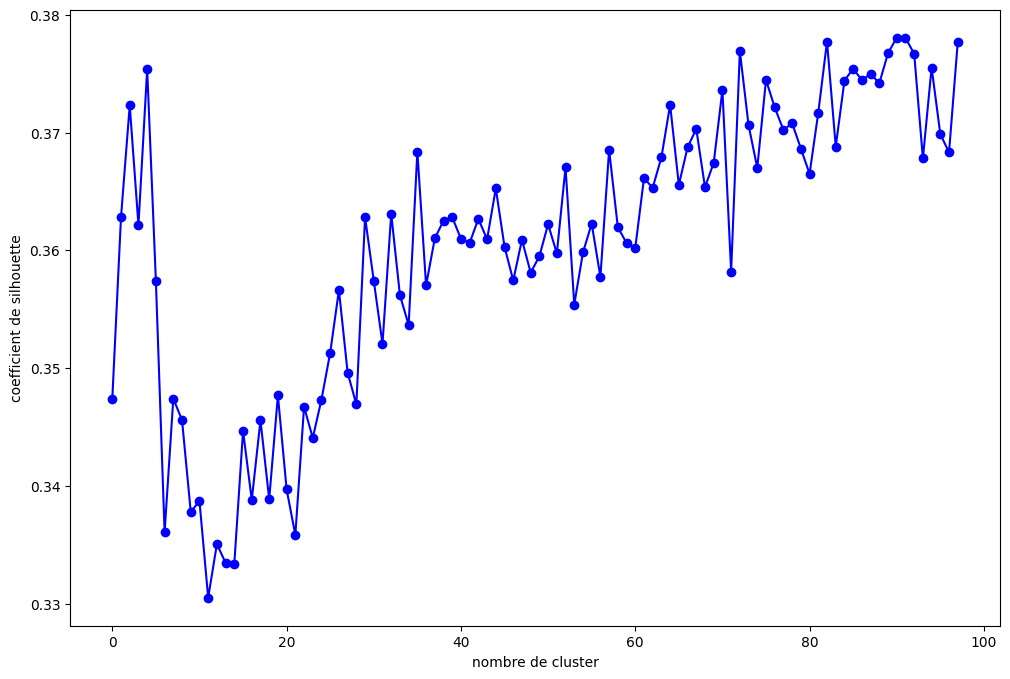

In [3]:
sil = []
for k in range(2,100):
    reduced_data = decomposition.PCA(n_components=2).fit_transform(ally.T)
    kmeans = cluster.KMeans(init="k-means++", n_clusters=k)
    kmeans.fit(reduced_data)
    sil.append(metrics.silhouette_score(reduced_data, kmeans.labels_, metric='euclidean'))


plt.figure(figsize = (12,8))
plt.plot(sil,'b-o')
plt.xlabel('nombre de cluster')
plt.ylabel('coefficient de silhouette')
plt.show()

Ensuite, on affiche l'indice de Rand en fonction du nombre de cluster. On peut voir sur la figure ci-dessous que plus on augmente le nombre de cluster plus l'indice de rand est bas.

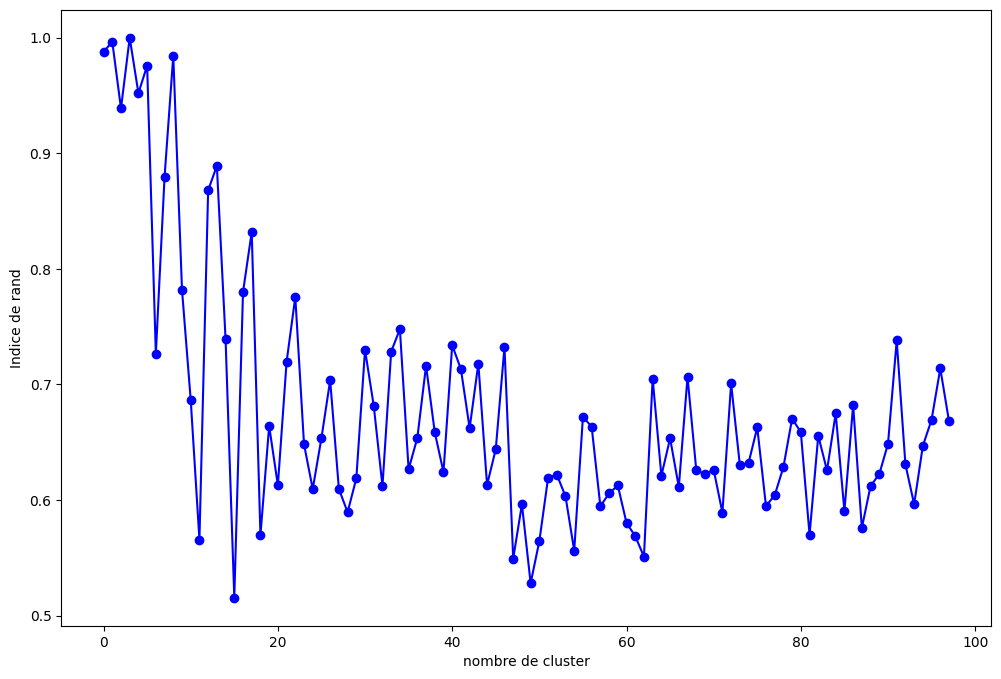

In [4]:
rand = []
for k in range(2,100):
    reduced_data = decomposition.PCA(n_components=2).fit_transform(ally.T)
    kmeans1 = cluster.KMeans(init="k-means++", n_clusters=k)
    kmeans1.fit(reduced_data)
    kmeans2 = cluster.KMeans(init="k-means++", n_clusters=k)
    kmeans2.fit(reduced_data)
    rand.append(metrics.adjusted_rand_score(kmeans1.labels_, kmeans2.labels_))

plt.figure(figsize = (12,8))
plt.plot(rand,'b-o')
plt.xlabel('nombre de cluster')
plt.ylabel('Indice de rand')
plt.show()

Du fait des observations réalisées sur le coefficient de silhouette et l'indice de rand, il est préferable de prendre un nombre de cluster égale à 6. Ainsi, on retrouve:

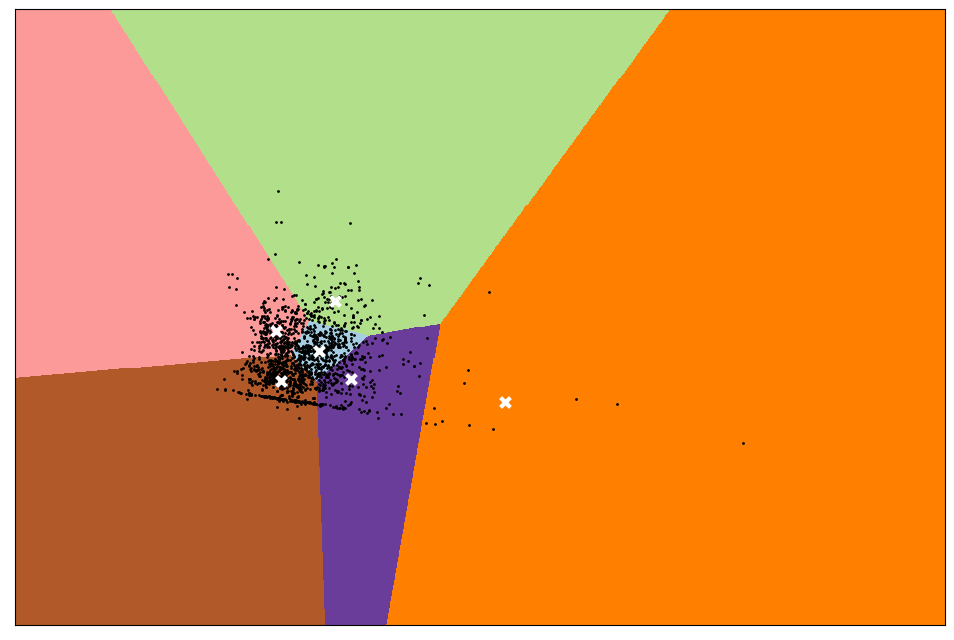

In [5]:
reduced_data = decomposition.PCA(n_components=2).fit_transform(ally.T)
kmeans = cluster.KMeans(init="k-means++", n_clusters=6)
kmeans.fit(reduced_data)


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.005  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize = (12,8))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=50,
    linewidths=3,
    color="w",
    zorder=10,
)
#plt.title("Clustering K-means sur les profils d'aile d'avion (PCA-reduced data)\n""Les centroides sont marquée avec des croix")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

On peut voir ci-dessus la repartition des profils dans les 6 clusters définis.

In [6]:
dict = { 'nom' : nom_profil , 'label' : list(kmeans.labels_)}
dataframe = pd.DataFrame(dict).sort_values(by='label')
display(dataframe)

,nom,label
1206,stf86361-il,0
538,s826-nr,0
534,goe655-il,0
531,v43015-il,0
1034,boe103-il,0
...,...,...
839,n64015a-il,5
840,s9033-il,5
841,c141b-il,5
768,mh22-il,5


### Pertinence du modèle pour l'application souhaitée
Dès lors, on ecrit une fonction qui nous permlet d'avoir les profils les plus proches d'un profil donnée avec ce modèle de clustering.

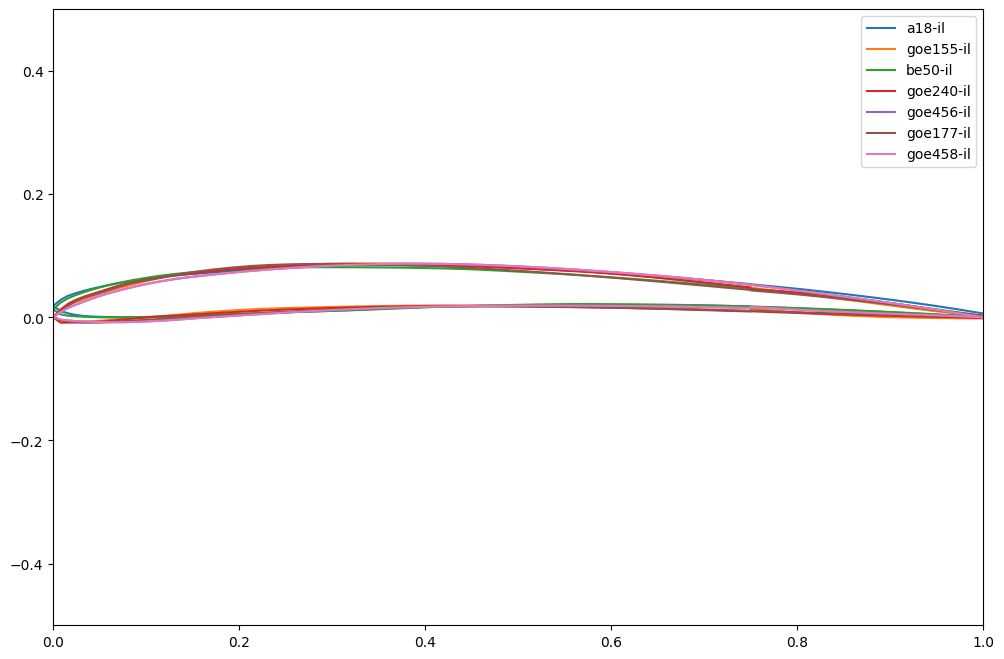

In [7]:
# Import airfoils gaussian Area  
aire_all = lb.air_profils(x,ally)
proche.plotWithAlly('a18-il',nom_profil,ally,aire_all,dir = r"../data/Airfoil_Coordinate")


On trace ci-dessous les profils. On peut voir que les profils affichés sont très proche geométriquement. Cela était attendu pour les GOE mais grâce à cette fonction on a pu établir un lien avec l’A-18. 

On décide maintenant de voir si les profils proches obtenus ont des étiquettes relativement proche aussi. C'est à dire une aire et des finesses proches pour un nombre de Mach et de Reynolds donnée. On importe alors les données d'aire et de finesses.

In [8]:
# Import airfoils gaussian Area  
aire_all = lb.air_profils(x,ally)

# On calcule la finesse max suivant les données de polaire
# qu'on possede
Re_list,finesse_max,nom_profil_tt_Re = label_fin.finesse_max(ally,nom_profil,dir = r'../data/Airfoil_Polar')

On affiche maintenant le tableau précedent avec les aires et finesses associée

In [9]:
profil = 'a18-il'
table, profil_proche = proche.profilWithAlly(profil,nom_profil,ally,aire_all,dir = r'../data/Airfoil_Polar' )

print(table.loc[table.index ==profil])
for i in range(len(profil_proche)):
    print(table.loc[table.index == profil_proche[i]])

        Classe      Aire  Re = 50000  Re = 100000  Re = 200000  Re = 500000  \
a18-il    54.0  0.083239        44.0         65.0         86.3        111.9   

        Re = 1000000  
a18-il         124.7  
           Classe      Aire  Re = 50000  Re = 100000  Re = 200000  \
goe439-il    54.0  0.099372        28.7         59.1         79.3   

           Re = 500000  Re = 1000000  
goe439-il        108.4         129.3  
           Classe      Aire  Re = 50000  Re = 100000  Re = 200000  \
goe199-il    54.0  0.083109         NaN         55.7         72.0   

           Re = 500000  Re = 1000000  
goe199-il         89.8         108.2  
           Classe      Aire  Re = 50000  Re = 100000  Re = 200000  \
goe428-il    54.0  0.099422        38.6         58.4         77.3   

           Re = 500000  Re = 1000000  
goe428-il        104.2         125.0  


### Modèle 2

On s'interesse maintenant à améliorer notre modèle on y intégrant des information supplémentaire comme l'aire ou la finesse. Un modèle avec la finesse associé à un nombre de Mach et de Reynolds ($f_{M_{RE_{i}}}$ avec $i\in[1,p]$) et l'aire ($A_i$ avec $i\in[1,p]$)
$$
Y_{e_{Re_1}} = \begin{bmatrix}
y_{11} &y_{21}&...&y_{n1} \\
y_{12} &y_{22}&...&y_{n2} \\
... &...&...&... \\
... &...&...&... \\
y_{1p} &y_{2p}&...&y_{np} \\
A_1 & A_2& ... & A_n\\
f_{M_{RE_{1}}} & f_{M_{RE_{2}}} & ... & f_{M_{RE_{p}}}\\
\end{bmatrix}
$$

On construis alors ce modèle

In [10]:
with open(r"../data/post_processed_data/Re_500000.pickle", "rb") as file:
    Re_500000 = pickle.load(file)

airfoil_name = Re_500000['nom']
A = Re_500000['aire']
finesse = Re_500000['finesse']

notinthisRe = []
ally_Re_500000 = []
i = 0
j = 0
for i in range(len(nom_profil)):
    if nom_profil[i]!= airfoil_name[j]:
        notinthisRe.append(i)
    else :
        j +=1

listdes_i = [i for i in range(n)]
for i in range(len(notinthisRe)):
   listdes_i.remove(i)

ally_Re_500000 = np.zeros((p,n-len(notinthisRe)))
i_temp = 0
for i in listdes_i:
    for j in range(p):
        ally_Re_500000[j,i_temp] = ally[j,i]
    i_temp +=1

p_1 = np.shape(ally_Re_500000)[0]
n_1 = np.shape(ally_Re_500000)[1]
y_model_1 = np.zeros((p_1+2,n_1))
for i in range(p_1):
    for j in range(n_1):
        y_model_1[i,j] = ally_Re_500000[i,j]

for j in range(n_1):
    y_model_1[-2,j] = A[j]
    y_model_1[-1,j] = finesse[j]
p_1 = np.shape(y_model_1)[0]
n_1 = np.shape(y_model_1)[1]
print(np.shape(y_model_1))

(120, 1586)


On réalise maintenant la décomposition en valeurs singulière

In [11]:
u_m1, d_m1,vh_m1 = np.linalg.svd(y_model_1, full_matrices=True)

# On verfie que la decomposition en valeur singulières a été reussi
d_mat_m1 = np.zeros((p_1, n_1), dtype=complex)
d_mat_m1[:p_1, :p_1] = np.diag(d_m1)
np.allclose(y_model_1, np.dot(u_m1, np.dot(d_mat_m1, vh_m1)))

True

On trace le scree plot

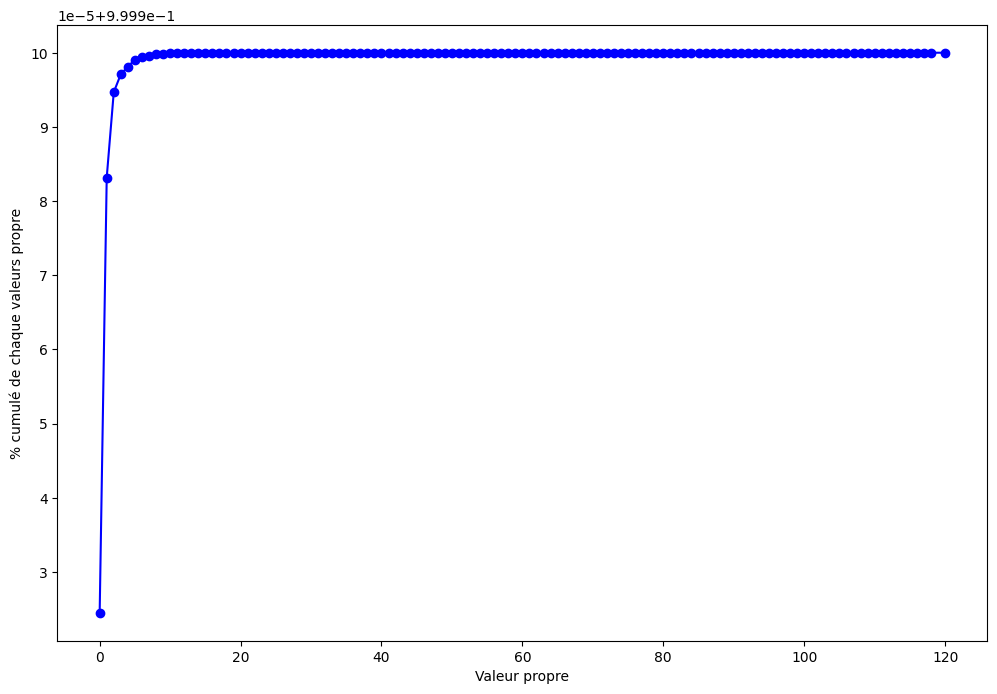

[0.9999244864360256, 0.9999831734926754]


In [12]:
k = np.linspace(0,p_1,p_1,dtype=int)

plt.figure(figsize=(12,8))
plt.plot(k,cp.proportion_var(d_m1,p_1),'b-o')
plt.xlabel('Valeur propre')
plt.ylabel('% cumulé de chaque valeurs propre')
plt.show()

print(cp.proportion_var(d_m1,p_1)[:2])

On peut voir que la première valeurs propres participe à 99,992 % de la variance totale et que les deux première à 99,999 % . On peut donc largement retenir celle-ci

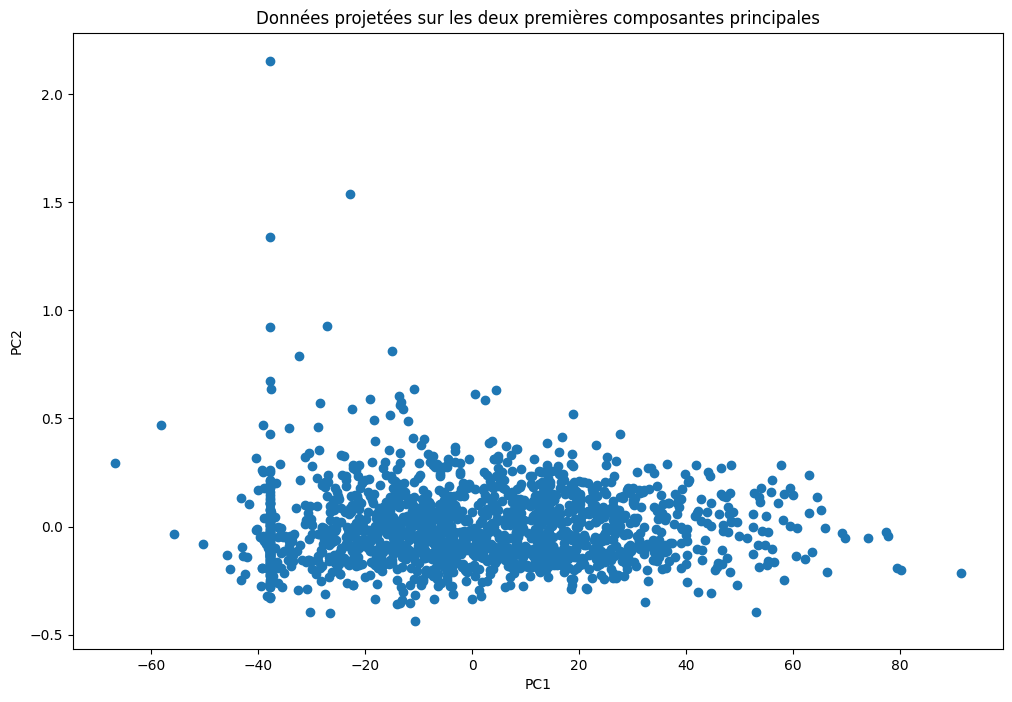

91.30473707730366 -66.80810250468909
2.1541832927564477 -0.4351702903960278


In [13]:
reduced_data_m1 = decomposition.PCA(n_components=2).fit_transform(y_model_1.T) 
plt.figure(figsize=(12,8))
plt.title('Données projetées sur les deux premières composantes principales')
plt.scatter(reduced_data_m1[:,0],reduced_data_m1[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

print(max(reduced_data_m1[:,0]),min(reduced_data_m1[:,0]))
print(max(reduced_data_m1[:,1]),min(reduced_data_m1[:,1]))

On lance alors le clustering. On s'interesse comme précedemment dans un premier temps au coefficient de silhouette et à l'indice de Rand

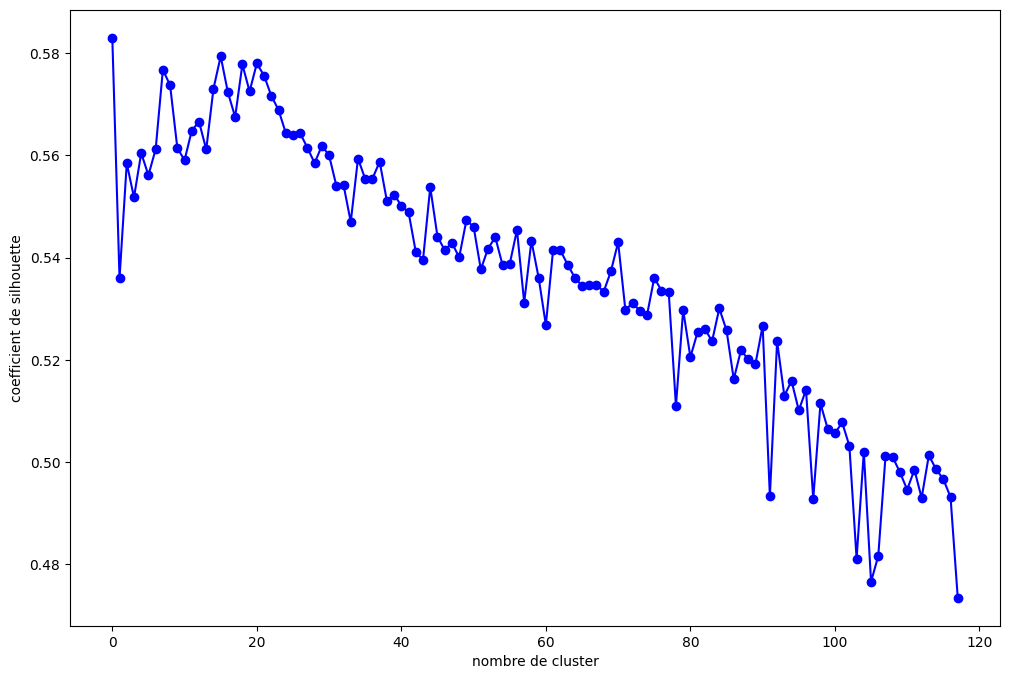

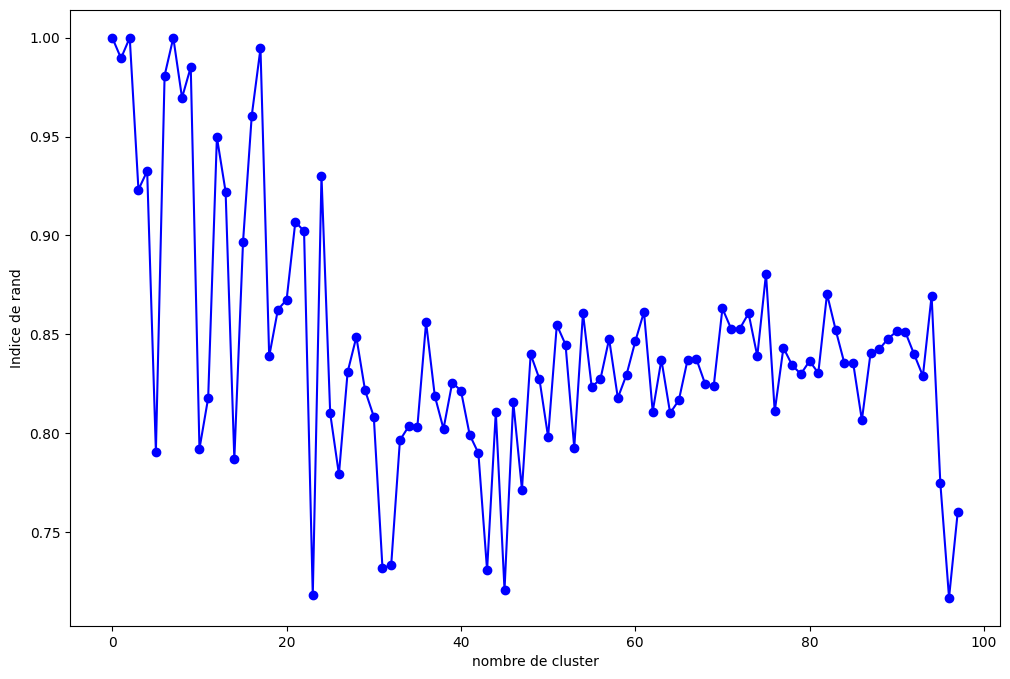

In [14]:
from sklearn import metrics

sil = []
for k in range(2,p_1):
    kmeans = cluster.KMeans(init="k-means++", n_clusters=k)
    kmeans.fit(reduced_data_m1)
    sil.append(metrics.silhouette_score(reduced_data_m1, kmeans.labels_, metric='euclidean'))


plt.figure(figsize = (12,8))
plt.plot(sil,'b-o')
plt.xlabel('nombre de cluster')
plt.ylabel('coefficient de silhouette')


rand = []
for k in range(2,100):
    kmeans1 = cluster.KMeans(init="k-means++", n_clusters=k)
    kmeans1.fit(reduced_data_m1)
    kmeans2 = cluster.KMeans(init="k-means++", n_clusters=k)
    kmeans2.fit(reduced_data_m1)
    rand.append(metrics.adjusted_rand_score(kmeans1.labels_, kmeans2.labels_))

plt.figure(figsize = (12,8))
plt.plot(rand,'b-o')
plt.xlabel('nombre de cluster')
plt.ylabel('Indice de rand')
plt.show()


On peut voir que l'indice de silhouette et l'indice de Rand sont plus grand que ceux du modèle de base et donc meilleurs. On peut voir que le nombre de cluster optimal en prenant en compte ces deux critère est __24__

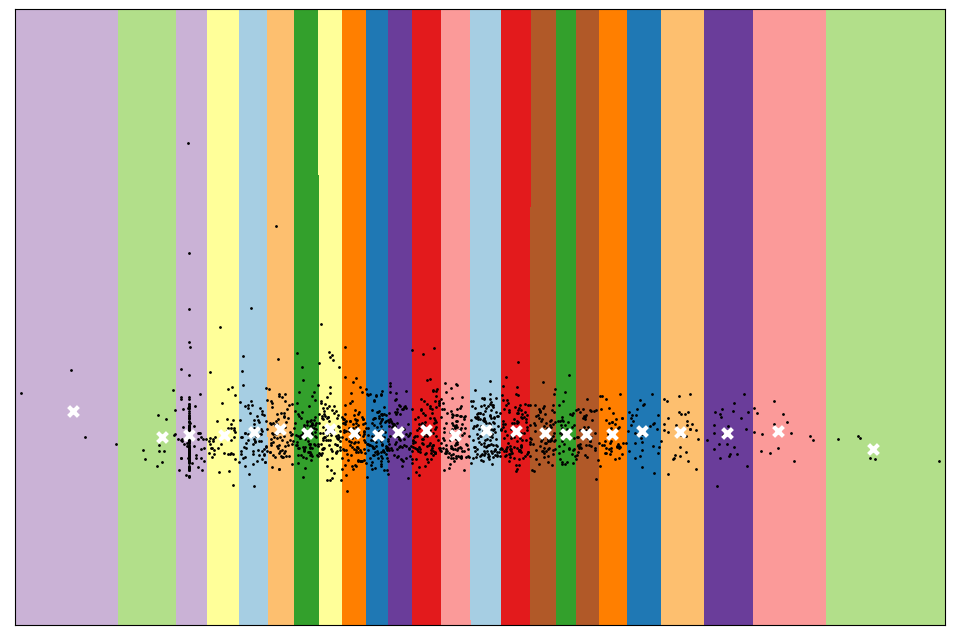

In [15]:
kmeans = cluster.KMeans(init="k-means++", n_clusters=24)
kmeans.fit(reduced_data_m1)


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.005  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data_m1[:, 0].min() - 1, reduced_data_m1[:, 0].max() + 1
y_min, y_max = reduced_data_m1[:, 1].min() - 1, reduced_data_m1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize = (12,8))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data_m1[:, 0], reduced_data_m1[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=50,
    linewidths=3,
    color="w",
    zorder=10,
)
#plt.title("Clustering K-means sur les profils d'aile d'avion (PCA-reduced data)\n""Les centroides sont marquée avec des croix")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Modèle 3

Un modèle avec la finesse associé à un nombre de Mach et de Reynolds ($f_{M_{RE_{i}}}$ avec $i\in[1,p]$):
$$
Y_{e_{Re_3}} = \begin{bmatrix}
y_{11} &y_{21}&...&y_{n1} \\
y_{12} &y_{22}&...&y_{n2} \\
... &...&...&... \\
... &...&...&... \\
y_{1p} &y_{2p}&...&y_{np} \\
f_{M_{RE_{1}}} & f_{M_{RE_{2}}} & ... & f_{M_{RE_{p}}}\\
\end{bmatrix}
$$

In [16]:
with open(r"../data/post_processed_data/Re_500000.pickle", "rb") as file:
    Re_500000 = pickle.load(file)

airfoil_name = Re_500000['nom']
A = Re_500000['aire']
finesse = Re_500000['finesse']

notinthisRe = []
ally_Re_500000 = []
i = 0
j = 0
for i in range(len(nom_profil)):
    if nom_profil[i]!= airfoil_name[j]:
        notinthisRe.append(i)
    else :
        j +=1

listdes_i = [i for i in range(n)]
for i in range(len(notinthisRe)):
   listdes_i.remove(i)

ally_Re_500000 = np.zeros((p,n-len(notinthisRe)))
i_temp = 0
for i in listdes_i:
    for j in range(p):
        ally_Re_500000[j,i_temp] = ally[j,i]
    i_temp +=1

p_2 = np.shape(ally_Re_500000)[0]
n_2 = np.shape(ally_Re_500000)[1]
y_model_2 = np.zeros((p_2+1,n_2))
for i in range(p_2):
    for j in range(n_2):
        y_model_2[i,j] = ally_Re_500000[i,j]

for j in range(n_2):
    y_model_1[-1,j] = finesse[j]
p_2 = np.shape(y_model_2)[0]
n_2 = np.shape(y_model_2)[1]
print(np.shape(y_model_2))

(119, 1586)


On réalise maintenant la décomposition en valeurs singulière

In [17]:
u_m2, d_m2,vh_m2 = np.linalg.svd(y_model_2, full_matrices=True)

# On verfie que la decomposition en valeur singulières a été reussi
d_mat_m2 = np.zeros((p_2, n_2), dtype=complex)
d_mat_m2[:p_2, :p_2] = np.diag(d_m2)
np.allclose(y_model_2, np.dot(u_m2, np.dot(d_mat_m2, vh_m2)))

True

On trace le scree plot

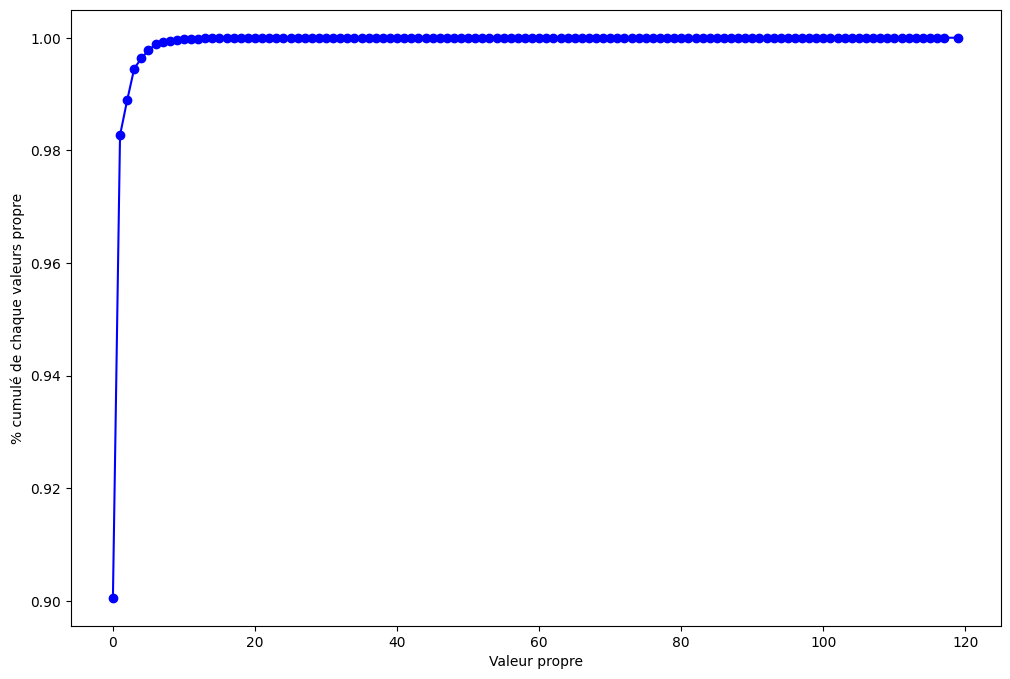

[0.9005456221299696, 0.9826801386857769]


In [18]:
k = np.linspace(0,p_2,p_2,dtype=int)

plt.figure(figsize=(12,8))
plt.plot(k,cp.proportion_var(d_m2,p_2),'b-o')
plt.xlabel('Valeur propre')
plt.ylabel('% cumulé de chaque valeurs propre')
plt.show()

print(cp.proportion_var(d_m2,p_2)[:2])

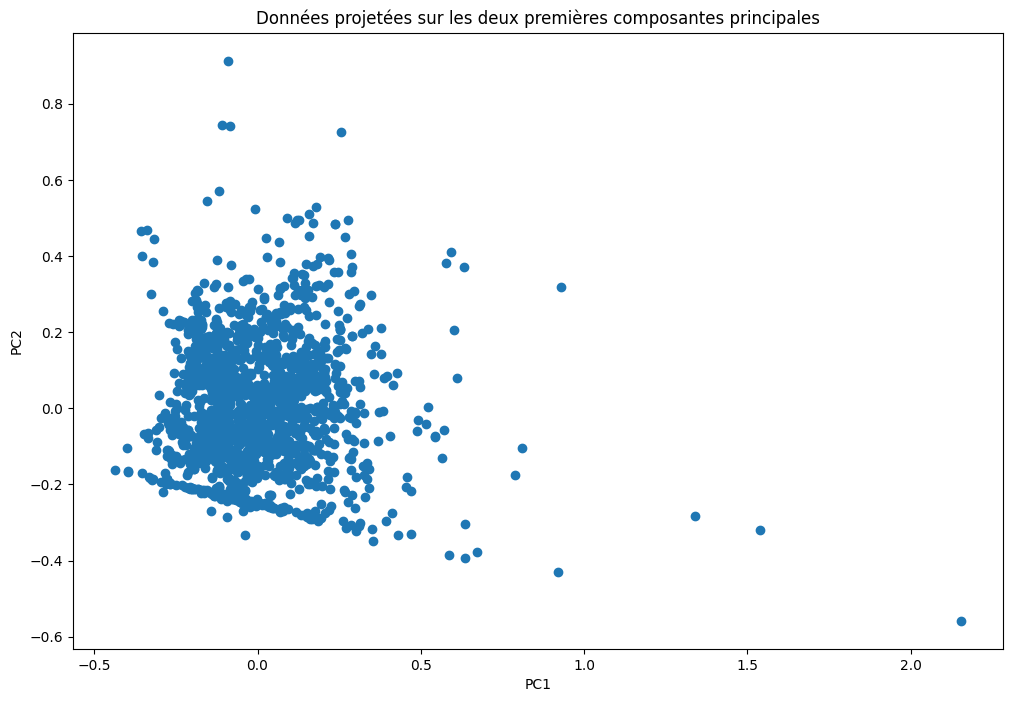

2.1525265877828406 -0.43576901470529444
0.9131058651494036 -0.5582034828938908


In [19]:
reduced_data_m2 = decomposition.PCA(n_components=2).fit_transform(y_model_2.T) 
plt.figure(figsize=(12,8))
plt.title('Données projetées sur les deux premières composantes principales')
plt.scatter(reduced_data_m2[:,0],reduced_data_m2[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

print(max(reduced_data_m2[:,0]),min(reduced_data_m2[:,0]))
print(max(reduced_data_m2[:,1]),min(reduced_data_m2[:,1]))

On lance alors le clustering. On s'interesse comme précedemment dans un premier temps au coefficient de silhouette et à l'indice de Rand

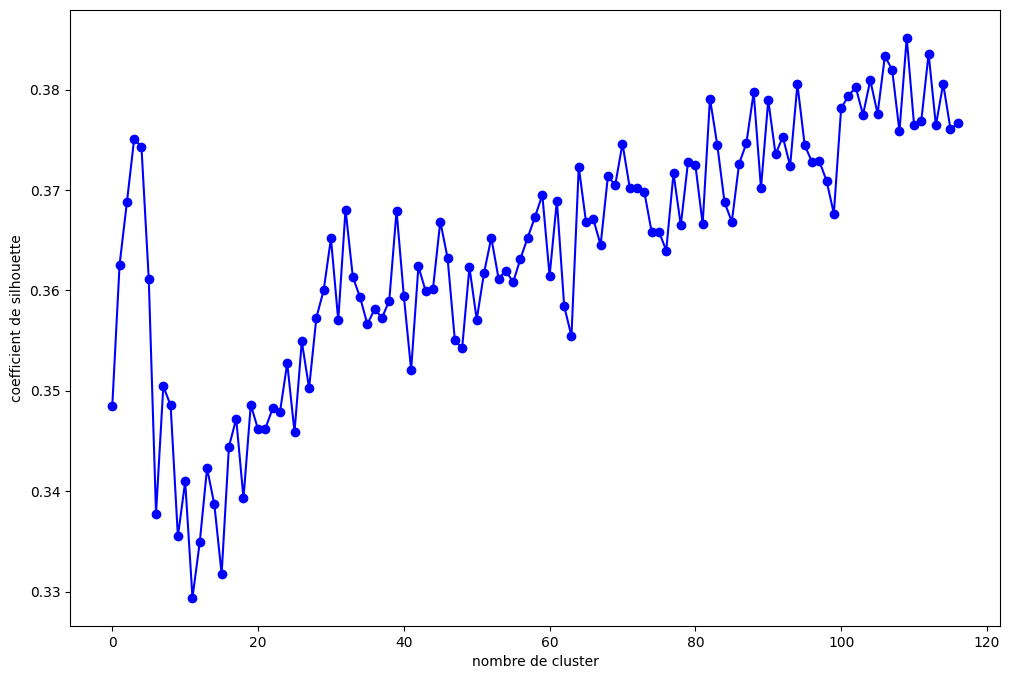

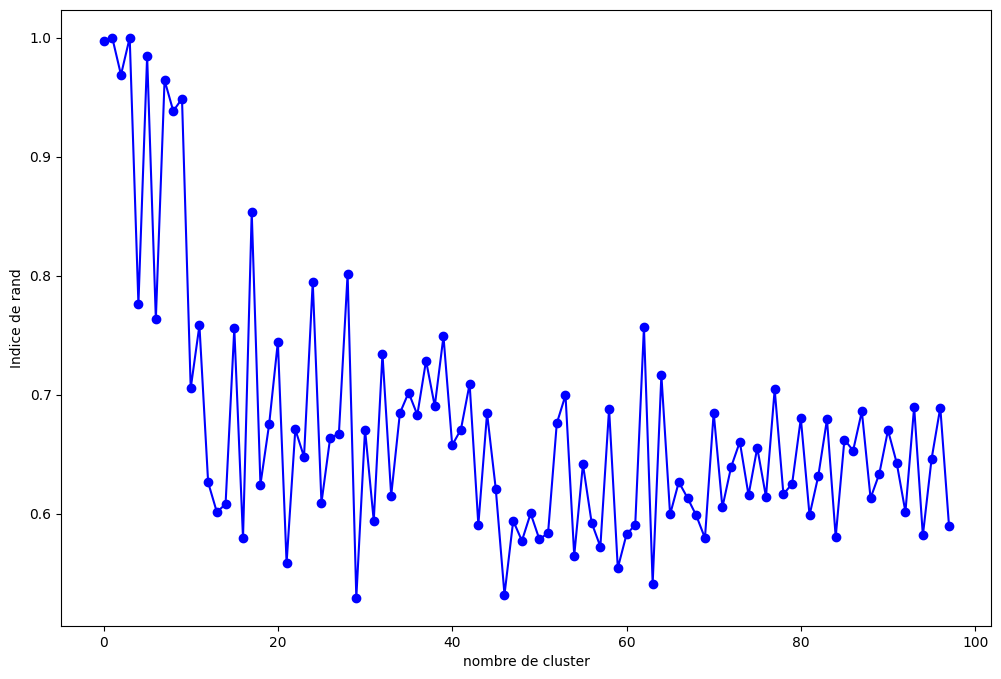

In [20]:
from sklearn import metrics

sil = []
for k in range(2,p_2):
    kmeans = cluster.KMeans(init="k-means++", n_clusters=k)
    kmeans.fit(reduced_data_m2)
    sil.append(metrics.silhouette_score(reduced_data_m2, kmeans.labels_, metric='euclidean'))


plt.figure(figsize = (12,8))
plt.plot(sil,'b-o')
plt.xlabel('nombre de cluster')
plt.ylabel('coefficient de silhouette')


rand = []
for k in range(2,100):
    kmeans1 = cluster.KMeans(init="k-means++", n_clusters=k)
    kmeans1.fit(reduced_data_m2)
    kmeans2 = cluster.KMeans(init="k-means++", n_clusters=k)
    kmeans2.fit(reduced_data_m2)
    rand.append(metrics.adjusted_rand_score(kmeans1.labels_, kmeans2.labels_))

plt.figure(figsize = (12,8))
plt.plot(rand,'b-o')
plt.xlabel('nombre de cluster')
plt.ylabel('Indice de rand')
plt.show()

On peut voir que l'indice de silhouette et l'indice de Rand sont plus grand que ceux du modèle de base et donc meilleurs. On peut voir que le nombre de cluster optimal en prenant en compte ces deux critère est __6__

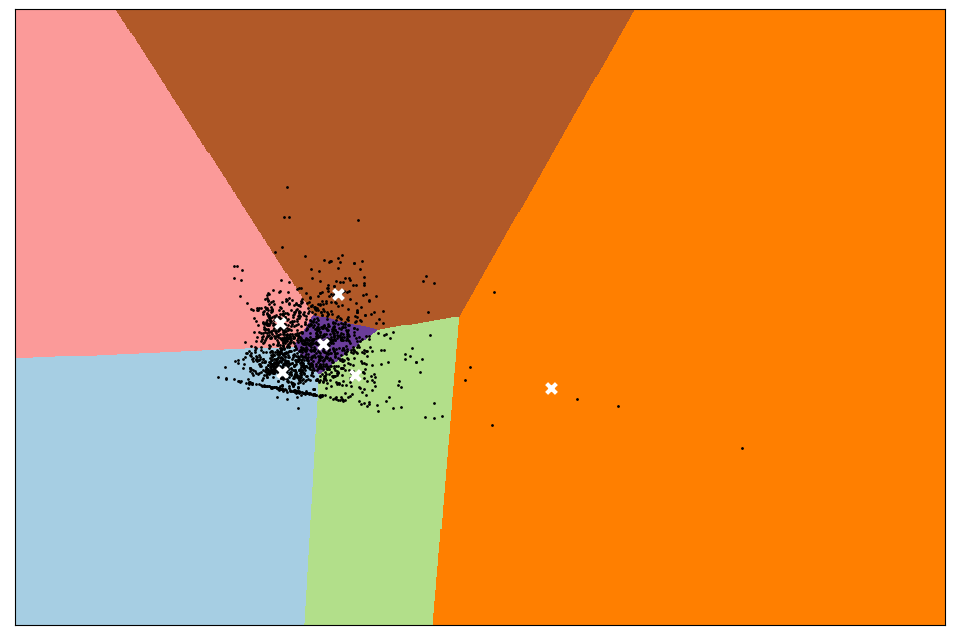

In [21]:
kmeans = cluster.KMeans(init="k-means++", n_clusters=6)
kmeans.fit(reduced_data_m2)


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.005  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data_m2[:, 0].min() - 1, reduced_data_m2[:, 0].max() + 1
y_min, y_max = reduced_data_m2[:, 1].min() - 1, reduced_data_m2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize = (12,8))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data_m2[:, 0], reduced_data_m2[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=50,
    linewidths=3,
    color="w",
    zorder=10,
)
#plt.title("Clustering K-means sur les profils d'aile d'avion (PCA-reduced data)\n""Les centroides sont marquée avec des croix")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Ce modèle se rapproche grandement du modèle de base. Ainsi, rajouter une seule données de finesse pour un Re ne semble pas très pertient

### Modèle 4

Un modèle avec la finesse associé à un nombre de Mach et tous les nombres de Reynolds ($f_{M_{RE_{ij}}}$ avec $i\in[1,p]$ et $j\in[1,5]$):
$$
Y_{e_4} = \begin{bmatrix}
y_{11} &y_{21}&...&y_{n1} \\
y_{12} &y_{22}&...&y_{n2} \\
... &...&...&... \\
... &...&...&... \\
y_{1p} &y_{2p}&...&y_{np} \\
f_{M_{RE_{11}}} & f_{M_{RE_{21}}} & ... & f_{M_{RE_{p1}}}\\
... &...&...&... \\
f_{M_{RE_{15}}} & f_{M_{RE_{25}}} & ... & f_{M_{RE_{p5}}}\\
\end{bmatrix}
$$

In [22]:
with open(r"../data/post_processed_data/Re_50000.pickle", "rb") as file:
    Re_50000 = pickle.load(file)

airfoil_name = Re_50000['nom']
A = Re_50000['aire']
finesse_1 = Re_50000['finesse']

notinthisRe_1 = []
i = 0
j = 0
for i in range(len(nom_profil)):
    if nom_profil[i]!= airfoil_name[j]:
        notinthisRe_1.append(i)
    else :
        j +=1

with open(r"../data/post_processed_data/Re_100000.pickle", "rb") as file:
    Re_100000 = pickle.load(file)

airfoil_name = Re_100000['nom']
A = Re_100000['aire']
finesse_2 = Re_100000['finesse']

notinthisRe_2 = []
i = 0
j = 0
for i in range(len(nom_profil)):
    if nom_profil[i]!= airfoil_name[j]:
        notinthisRe_2.append(i)
    else :
        j +=1


with open(r"../data/post_processed_data/Re_200000.pickle", "rb") as file:
    Re_200000 = pickle.load(file)

airfoil_name = Re_200000['nom']
A = Re_200000['aire']
finesse_3 = Re_200000['finesse']

notinthisRe_3 = []
i = 0
j = 0
for i in range(len(nom_profil)):
    if nom_profil[i]!= airfoil_name[j]:
        notinthisRe_3.append(i)
    else :
        j +=1

with open(r"../data/post_processed_data/Re_500000.pickle", "rb") as file:
    Re_500000 = pickle.load(file)

airfoil_name = Re_500000['nom']
A = Re_500000['aire']
finesse_4 = Re_500000['finesse']

notinthisRe_4 = []
i = 0
j = 0
for i in range(len(nom_profil)):
    if nom_profil[i]!= airfoil_name[j]:
        notinthisRe_4.append(i)
    else :
        j +=1

with open(r"../data/post_processed_data/Re_1000000.pickle", "rb") as file:
    Re_1000000 = pickle.load(file)

airfoil_name = Re_1000000['nom']
A = Re_1000000['aire']
finesse_5 = Re_1000000['finesse']

notinthisRe_5 = []
i = 0
j = 0
for i in range(len(nom_profil)):
    if nom_profil[i]!= airfoil_name[j]:
        notinthisRe_5.append(i)
    else :
        j +=1


# On concatene toutes les listes
notinthisRe = notinthisRe_1 + notinthisRe_2 + notinthisRe_3 + notinthisRe_4 + notinthisRe_5
notinthisRe  = list(set(notinthisRe)) # On enleve les doublons

listdes_i = [i for i in range(n)]
for i in range(len(notinthisRe)):
   listdes_i.remove(i)
   aire_all.remove(aire_all[i])


ally_Re = np.zeros((p,n-len(notinthisRe)))
i_temp = 0
for i in listdes_i:
    for j in range(p):
        ally_Re[j,i_temp] = ally[j,i]
    i_temp +=1


p_3 = np.shape(ally_Re)[0]
n_3 = np.shape(ally_Re)[1]
y_model_3 = np.zeros((p_3+6,n_3))
for i in range(p_3):
    for j in range(n_3):
        y_model_3[i,j] = ally_Re[i,j]

for j in range(n_3):
    y_model_3[-6,j] = aire_all[j]
    y_model_3[-5,j] = finesse_1[j]
    y_model_3[-4,j] = finesse_2[j]
    y_model_3[-3,j] = finesse_3[j]
    y_model_3[-2,j] = finesse_4[j]
    y_model_3[-1,j] = finesse_5[j]

p_3 = np.shape(y_model_3)[0]
n_3 = np.shape(y_model_3)[1]
print(np.shape(y_model_3))

FileNotFoundError: [Errno 2] No such file or directory: 'data/post_processed_data/Re_50000.pickle'

On réalise maintenant la décomposition en valeurs singulière

In [ ]:
u_m3, d_m3,vh_m3 = np.linalg.svd(y_model_3, full_matrices=True)

# On verfie que la decomposition en valeur singulières a été reussi
d_mat_m3 = np.zeros((p_3, n_3), dtype=complex)
d_mat_m3[:p_3, :p_3] = np.diag(d_m3)
np.allclose(y_model_3, np.dot(u_m3, np.dot(d_mat_m3, vh_m3)))

On trace le scree plot

In [ ]:
k = np.linspace(0,p_3,p_3,dtype=int)

plt.figure(figsize=(12,8))
plt.plot(k,cp.proportion_var(d_m3,p_3),'b-o')
plt.xlabel('Valeur propre')
plt.ylabel('% cumulé de chaque valeurs propre')
plt.show()

print(cp.proportion_var(d_m3,p_3)[:2])

In [ ]:
reduced_data_m3 = decomposition.PCA(n_components=2).fit_transform(y_model_3.T) 
plt.figure(figsize=(12,8))
plt.title('Données projetées sur les deux premières composantes principales')
plt.scatter(reduced_data_m3[:,0],reduced_data_m3[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

print(max(reduced_data_m3[:,0]),min(reduced_data_m3[:,0]))
print(max(reduced_data_m3[:,1]),min(reduced_data_m3[:,1]))

On lance alors le clustering. On s'interesse comme précedemment dans un premier temps au coefficient de silhouette et à l'indice de Rand

In [ ]:
sil = []
for k in range(2,p_3):
    kmeans = cluster.KMeans(init="k-means++", n_clusters=k)
    kmeans.fit(reduced_data_m3)
    sil.append(metrics.silhouette_score(reduced_data_m3, kmeans.labels_, metric='euclidean'))


plt.figure(figsize = (12,8))
plt.plot(sil,'b-o')
plt.xlabel('nombre de cluster')
plt.ylabel('coefficient de silhouette')


rand = []
for k in range(2,p_3):
    kmeans1 = cluster.KMeans(init="k-means++", n_clusters=k)
    kmeans1.fit(reduced_data_m3)
    kmeans2 = cluster.KMeans(init="k-means++", n_clusters=k)
    kmeans2.fit(reduced_data_m3)
    rand.append(metrics.adjusted_rand_score(kmeans1.labels_, kmeans2.labels_))

plt.figure(figsize = (12,8))
plt.plot(rand,'b-o')
plt.xlabel('nombre de cluster')
plt.ylabel('Indice de rand')
plt.show()

Du fait des données et de leurs 2 premières composantes principale il est impossible de réaliser un clustering K-means avec ce modèle. 

### Modèle 5

Un modèle avec l'aire ($A_i$ avec $i\in[1,p]$) uniquement
$$
Y_{e_{Re_1}} = \begin{bmatrix}
y_{11} &y_{21}&...&y_{n1} \\
y_{12} &y_{22}&...&y_{n2} \\
... &...&...&... \\
... &...&...&... \\
y_{1p} &y_{2p}&...&y_{np} \\
A_1 & A_2& ... & A_n\\
\end{bmatrix}
$$

On construis alors ce modèle

In [ ]:
y_model_4 = np.zeros((p+1,n))
for i in range(p):
    for j in range(n):
        y_model_4[i,j] = ally[i,j]

aire_all = air_profils(x,ally)
for j in range(n):
    y_model_4[-1,j] = aire_all[j]

p_4 = np.shape(y_model_4)[0]
n_4 = np.shape(y_model_4)[1]
print(np.shape(y_model_4))

On réalise maintenant la décomposition en valeurs singulière

In [ ]:
u_m4, d_m4,vh_m4 = np.linalg.svd(y_model_4, full_matrices=True)

# On verfie que la decomposition en valeur singulières a été reussi
d_mat_m4 = np.zeros((p_4, n_4), dtype=complex)
d_mat_m4[:p_4, :p_4] = np.diag(d_m4)
np.allclose(y_model_4, np.dot(u_m4, np.dot(d_mat_m4, vh_m4)))


On trace le scree plot

In [ ]:
k = np.linspace(0,p_4,p_4,dtype=int)

plt.figure(figsize=(12,8))
plt.plot(k,cp.proportion_var(d_m4,p_4),'b-o')
plt.xlabel('Valeur propre')
plt.ylabel('% cumulé de chaque valeurs propre')
plt.show()

print(cp.proportion_var(d_m4,p_4)[:2])

On peut voir que la première valeurs propres participe à 99,992 % de la variance totale et que les deux première à 99,999 % . On peut donc largement retenir celle-ci

In [ ]:
reduced_data_m4 = decomposition.PCA(n_components=2).fit_transform(y_model_4.T) 
plt.figure(figsize=(12,8))
plt.title('Données projetées sur les deux premières composantes principales')
plt.scatter(reduced_data_m4[:,0],reduced_data_m4[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

print(max(reduced_data_m4[:,0]),min(reduced_data_m4[:,0]))
print(max(reduced_data_m4[:,1]),min(reduced_data_m4[:,1]))

On lance alors le clustering. On s'interesse comme précedemment dans un premier temps au coefficient de silhouette et à l'indice de Rand

In [ ]:
from sklearn import metrics

sil = []
for k in range(2,p_4):
    kmeans = cluster.KMeans(init="k-means++", n_clusters=k)
    kmeans.fit(reduced_data_m4)
    sil.append(metrics.silhouette_score(reduced_data_m4, kmeans.labels_, metric='euclidean'))


plt.figure(figsize = (12,8))
plt.plot(sil,'b-o')
plt.xlabel('nombre de cluster')
plt.ylabel('coefficient de silhouette')


rand = []
for k in range(2,100):
    kmeans1 = cluster.KMeans(init="k-means++", n_clusters=k)
    kmeans1.fit(reduced_data_m4)
    kmeans2 = cluster.KMeans(init="k-means++", n_clusters=k)
    kmeans2.fit(reduced_data_m4)
    rand.append(metrics.adjusted_rand_score(kmeans1.labels_, kmeans2.labels_))

plt.figure(figsize = (12,8))
plt.plot(rand,'b-o')
plt.xlabel('nombre de cluster')
plt.ylabel('Indice de rand')
plt.show()

On peut voir que l'indice de silhouette et l'indice de Rand sont plus grand que ceux du modèle de base et donc meilleurs. On peut voir que le nombre de cluster optimal en prenant en compte ces deux critère est __6__

In [ ]:
kmeans = cluster.KMeans(init="k-means++", n_clusters=6)
kmeans.fit(reduced_data_m4)


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.005  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data_m4[:, 0].min() - 1, reduced_data_m4[:, 0].max() + 1
y_min, y_max = reduced_data_m4[:, 1].min() - 1, reduced_data_m4[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize = (12,8))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data_m4[:, 0], reduced_data_m4[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=50,
    linewidths=3,
    color="w",
    zorder=10,
)
#plt.title("Clustering K-means sur les profils d'aile d'avion (PCA-reduced data)\n""Les centroides sont marquée avec des croix")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

On cherche alors à savoir si les profils proches issus de ce modèle sont plus intéressants:

In [ ]:
def profil_tableau(name,y_model,Re,ally, nom_profil, nb_cluster = 400):
        
    # On importe les données associées au nombre de Reynolds
    dict_Re = proche.importRe(Re)
    nom_profil_Re = dict_Re['nom']
    aire = dict_Re['aire']
    finesse = dict_Re['finesse']

    # On réalise la réduction dimensionnelle 
    # ainsi que le clustering
    reduced_data = decomposition.PCA(n_components=2).fit_transform(y_model.T)
    kmeans = cluster.KMeans(init="k-means++", n_clusters=nb_cluster)
    kmeans.fit(reduced_data)
    
    # Définition des colones et lignes du tableau pandas
    columns = ['Classe','Aire','Finesse']
    index = nom_profil_Re
    k = len(nom_profil_Re)

    # On crée une matrice data qui regroupe les données qu'on
    # veut afficher
    data = np.zeros((k,3))
    for i in range(len(nom_profil_Re)):
        data[i,0] = list(kmeans.labels_)[i]
        data[i,1] = aire[i]
        data[i,2] = finesse[i]
    
    # On crée le tableau
    table = pd.DataFrame(data=data,index=index,columns=columns)

    # Recuperation de l'indice du profil dans la list des noms
    index_name = list(table.index).index(name)
    # Récupération de la classe du profil
    index_clust = list(table['Classe'])[index_name]

    newtable = table[table.Classe == index_clust]

    return newtable

newtable = profil_tableau('a18-il',y_model_4,500000,ally, nom_profil, nb_cluster = 400)
newtable

### Comparaison

Ainsi, le meilleur modèle proposé à l'étude est le premiers. On developpe donc une fonction qui nous permet d'avoir un clustering en fonction du nombre de Mach (dans notre cas toujours 0) et du nombre de Reynolds (de 50000 à 1000000).

On developpe alors une fonction qui donne en sortie un tableau avec les profils dont on a les données pour ce nombre de Reynolds, leur finesse, leur cluster et leur aire. On enregistre alors ce tableau afin d'avoir des cluster stable et palier au faible indice de Rand du au haut nombre de cluster demandé

In [ ]:
table  = proche.profil_tableau(500000,ally, nom_profil)
table

Ainsi, on devellope une fonction qui permet d'obtenir pour un profil donné ces plus proches voisins

In [ ]:
newtable = proche.profilWithMemory('a18-il',500000)
newtable


On peut voir que ce clustering permet d'avoir des profils dont la finesse est très proche et des aires relativement proches à la différence du premier clustering qui donnait seulement des profils avec une aires proche. On peut egalement tracer les coordonnées des profils 

In [ ]:
proche.plotWithMemory('a18-il',500000)